In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from wrangle import wrangle_zillow, acquire_sec
from evaluate import baseline_mean_errors, better_than_baseline, regression_errors, plot_residuals, optimal_scaler, pearsonr_stats_test
from explore import plot_categorical_and_continuous_vars, plot_variable_pairs
from sklearn.feature_selection import SelectKBest, f_regression, RFE

# Regression Project

## Acquisition & Preparation (Wrangle)

In [2]:
# pull original dataframe through acquire and prep function
df = wrangle_zillow()
# pull secondary dataframe that added only properties sold in 2017
df_2 = acquire_sec()
df_2 = df_2.drop(columns={'latitude', 'longitude', 'lotsizesquarefeet', 'transactiondate'})
# join the two dataframes into one
df = df.merge(df_2, how='inner').drop(columns = 'parcelid')
# create a dataframe for homes only in LA County
la_df = df[df.county == 6037]
# create a dataframe for homes only in Orange County
orange_df = df[df.county == 6059]
# create a dataframe for homes only in Ventura County
ventura_df = df[df.county == 6111]

### We've now pulled in and cleaned the data through some functions we made

In [3]:
df_train_and_validate, df_test = train_test_split(df, random_state=117)
df_train, df_validate = train_test_split(df_train_and_validate)
df_x_train = df_train.drop(columns={'value'})
df_y_train = df_train['value']
df_x_validate = df_validate.drop(columns={'value'})
df_y_validate = df_validate['value']

In [4]:
la_train_and_validate, la_test = train_test_split(la_df, random_state=117)
la_train, la_validate = train_test_split(la_train_and_validate)
la_x_train = la_train.drop(columns={'value'})
la_y_train = la_train['value']
la_x_validate = la_validate.drop(columns={'value'})
la_y_validate = la_validate['value']

In [5]:
orange_train_and_validate, orange_test = train_test_split(orange_df, random_state=117)
orange_train, orange_validate = train_test_split(orange_train_and_validate)
orange_x_train = orange_train.drop(columns={'value'})
orange_y_train = orange_train['value']
orange_x_validate = orange_validate.drop(columns={'value'})
orange_y_validate = orange_validate['value']

In [6]:
ventura_train_and_validate, ventura_test = train_test_split(ventura_df, random_state=117)
ventura_train, ventura_validate = train_test_split(ventura_train_and_validate)
ventura_x_train = ventura_train.drop(columns={'value'})
ventura_y_train = ventura_train['value']
ventura_x_validate = ventura_validate.drop(columns={'value'})
ventura_y_validate = ventura_validate['value']

In [7]:
df_train.corr()

,beds,baths,square_feet,value,year_built,county
beds,1.000000,0.646545,0.636762,0.279188,0.383351,0.138004
baths,0.646545,1.000000,0.852795,0.520536,0.519614,0.107905
square_feet,0.636762,0.852795,1.000000,0.595623,0.451252,0.110066
value,0.279188,0.520536,0.595623,1.000000,0.163955,0.019941
year_built,0.383351,0.519614,0.451252,0.163955,1.000000,0.295179
county,0.138004,0.107905,0.110066,0.019941,0.295179,1.000000


## Exploration

### Initial Hypothesis: Square footage and the year a property was built are the most significant drivers to home value in all three counties

#### LA County Correlation Score

 	correlation	 beds	 	baths		sqr_feet	value		year_built	
 	beds 	 	 1.000000	0.663703	0.655651	0.287232	0.380993	
 	baths	 	 0.663703	1.000000	0.847428	0.500866	0.471821	
 	square_feet	 0.655651	0.847428	1.000000	0.590382	0.386679	
 	value	 	 0.287232	0.500866	0.590382	1.000000	0.083379	
 	year_built	 0.380993	0.471821	0.386679	0.083379	1.000000	

#### Square Feet had the largest correlation score here at 59.04

#### Orange County Correlation Score

	correlation	beds		baths		square_feet	value		year_built	
	beds		1.000000	0.591090	0.591202	0.283499	0.263009	
	baths		0.591090	1.000000	0.864445	0.598624	0.602971	
	square_feet	0.591202	0.864445	1.000000	0.664888	0.545728	
	value		0.283499	0.598624	0.664888	1.000000	0.379871	
	year_built	0.263009	0.602971	0.545728	0.379871	1.000000

#### Square Feet had the largest correlation score here at 66.49

#### Ventura County Correlation Score

	correlation	beds		baths		square_feet	value		year_built	
	beds		1.000000	0.597532	0.586668	0.314780	0.339595	
	baths		0.597532	1.000000	0.869202	0.589784	0.572456	
	square_feet	0.586668	0.869202	1.000000	0.698185	0.536259	
	value		0.314780	0.589784	0.698185	1.000000	0.383534	
	year_built	0.339595	0.572456	0.536259	0.383534	1.000000

#### Square Feet had the largest correlation score here at 69.82

### We found 'Square Feet' had the largest correlation so that was the primary feature we looked at

### After running a pearsonr stats test on our three separate dataframes, we rejected the null hypothesis for each of them showing statistical significance.

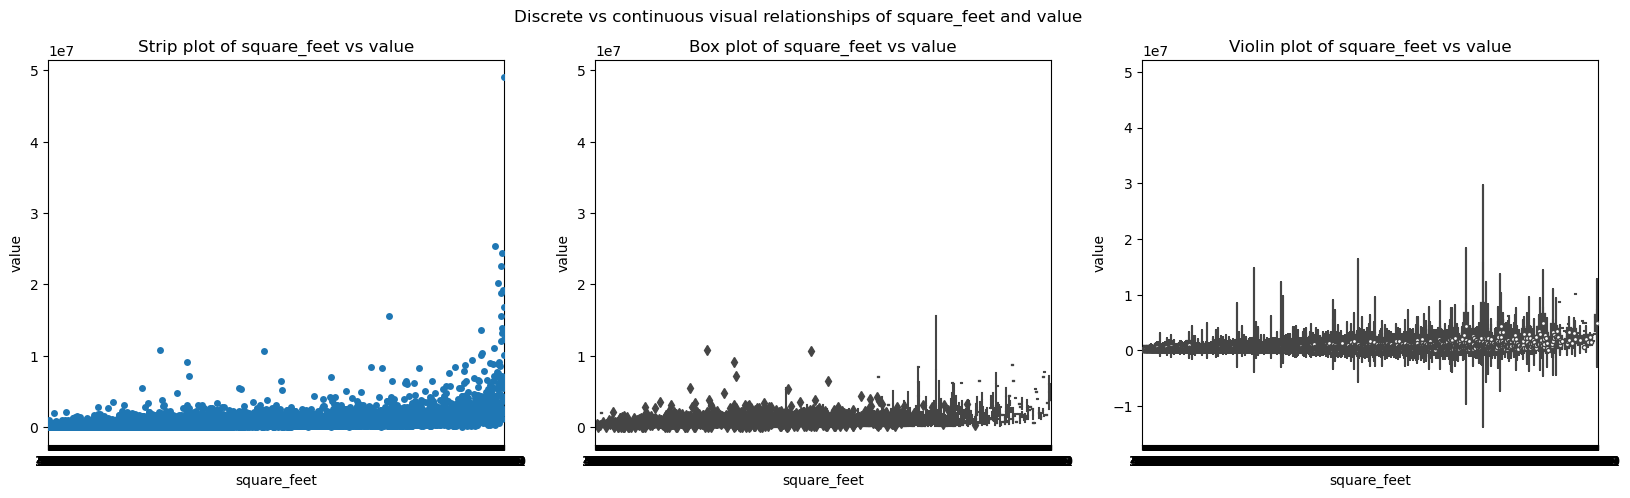

In [8]:
# plotting our strongest feature 'square feet' as a box plot, strip plot, and violin plot
plot_categorical_and_continuous_vars('square_feet','value', la_train)

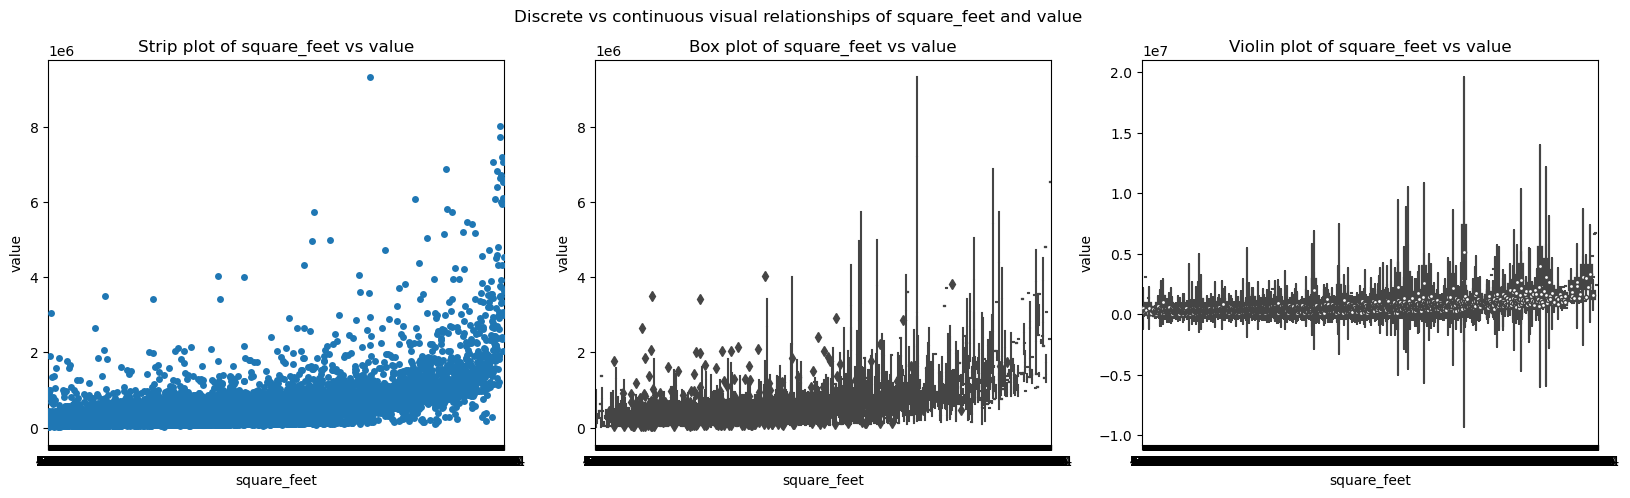

In [9]:
# plotting our strongest feature 'square feet' as a box plot, strip plot, and violin plot
plot_categorical_and_continuous_vars('square_feet','value', orange_train)

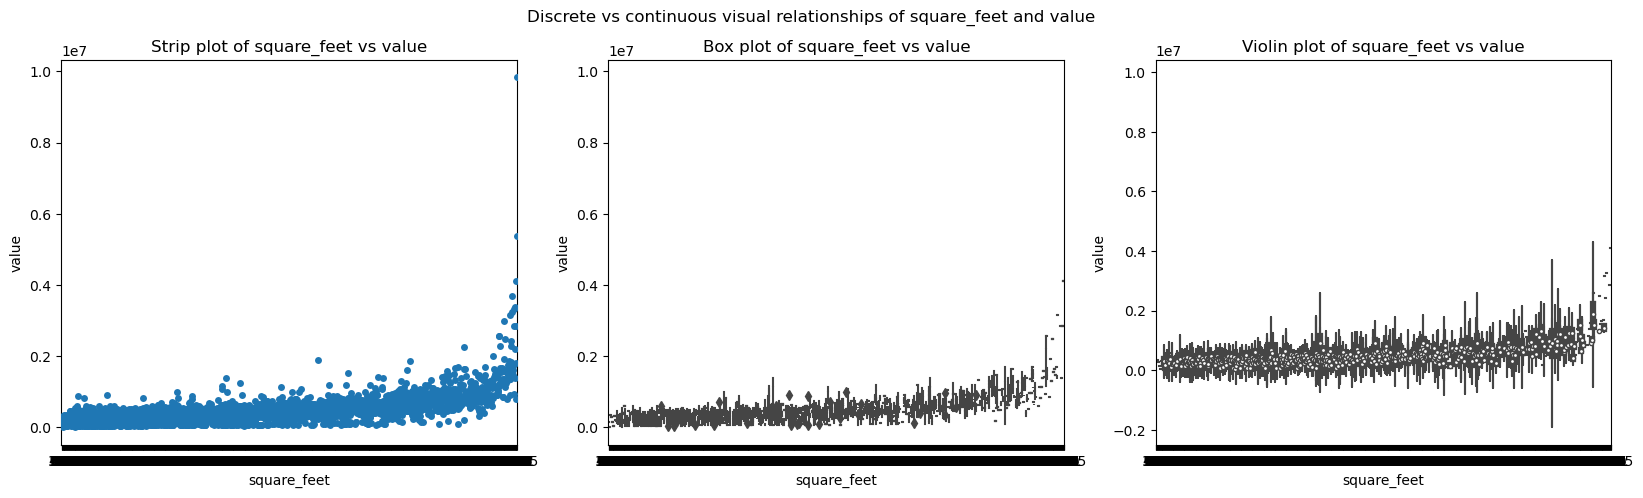

In [10]:
# plotting our strongest feature 'square feet' as a box plot, strip plot, and violin plot
plot_categorical_and_continuous_vars('square_feet','value', ventura_train)

## Modeling

### To see if there was any significant changes, we ran 8 models on all three different counties, LA County, Orange County, and Ventura County

### Validation Models

| La County | | Model | RMSE | R2 | | Orange County | Model | RMSE | R2 | | Ventura County | Model | RMSE | R2 |
| :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- |
| | | Baseline | 842,736.9 | 0.000000 | | | Baseline | 621,870.9 | 0.000000 | | | Baseline | 478,159.7 | 0.000000 |
| | | OLS_1 | 722,022.8 | 0.278420 | | | OLS_1 | 477,503.3 | 0.392668 | | | OLS_1 | 332,291.7 | 0.533713 |
| | | OLS | 703,790.3 | 0.314403 | | | OLS | 467,942.9 | 0.416744 | | | OLS | 324,850.2 | 0.554364 |
| | | Lars | 703,790.0 | 0.314403 | | | Lars | 467,943.2 | 0.416743 | | | Lars | 324,850.9 | 0.554362 |
| | | Poly Reg deg 2 | 688,306.1	| 0.344239 | | | Poly Reg deg 2 | 446,254.7 | 0.469557 | | | Poly Reg deg 2 | 264,625.8 | 0.704282 |
| | | Poly Reg deg 3 | 674,151.5	| 0.370932 | | | Poly Reg deg 3 | 435,161.8 | 0.495600 | | | Poly Reg deg 3 | 275,442 | 0.679613 |
| | | TweedieRegressor 1 | 729,953.1	| 0.262482 | | | TweedieRegressor 1 | 451,828.7 | 0.456223 | | | TweedieRegressor 1 | 244,806.4 | 0.746919 |
| | | TweedieRegressor 2 | 703,790.3	| 0.314403 | | | TweedieRegressor 2 | 467,942.9 | 0.416744 | | | TweedieRegressor 2 | 324,850.3 | 0.554364 |
| | | TweedieRegressor 3 | 9,300,201	| -118.720117 | | | TweedieRegressor 3 | 465,958.6 | 0.421680 | | | TweedieRegressor 3 | 320,104.1 | 0.567290 |

#### LA County:

##### Polynomial Regression with a degree of 3 outperformed the baseline by about $169k

#### Orange County:

##### Polynomial Regression with a degree of 3 outperformed the baseline by about $187k

#### Ventura County:

##### TweedieRegressor 1 with a power of 1, alpha of 0 outperformed the baseline by about 233k